In [1]:
# !pip install torchaudio librosa
import os
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import torchaudio
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
from torch.nn import init
import math
import warnings
warnings.filterwarnings('ignore')
plt.style.use(['nature', 'science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

In [430]:
def load_audio_files(path: str, label:str, resample_rate=16000, duration=60, slice_length=600, offset=0):
    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.mp3'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker = path.split('/')[-1]
        # Load audio as slices
        for i, t in enumerate(range(offset, slice_length+offset, duration)):
            waveform, _ = librosa.load(file_path, sr=resample_rate, offset=t, duration=duration, mono=True)
            dataset.append([waveform, resample_rate, label, filename.replace('.mp3', ''), i])
    return dataset

In [431]:
# LyndonBJohnson = load_audio_files(f'../audio/Lyndon B. Johnson', 'Lyndon B. Johnson')
# RichardMNixon = load_audio_files(f'../audio/Richard M. Nixon', 'Richard M. Nixon')
# BillClinton = load_audio_files(f'../audio/Bill Clinton', 'Bill Clinton')
# JohnFKennedy = load_audio_files(f'../audio/John F. Kennedy', 'John F. Kennedy')
# RenaldReagan = load_audio_files('../audio/Ronald Reagan', 'Ronald Reagan')
# GeorgeHWBush = load_audio_files('../audio/George H. W. Bush', 'George H. W. Bush')
# GeorgeWBush = load_audio_files('../audio/George W. Bush', 'George W. Bush')
# BarackObama = load_audio_files('../audio/Barack Obama', 'Barack Obama')
# FranklinDRoosevelt = load_audio_files('../audio/Franklin D. Roosevelt', 'Franklin D. Roosevelt')
JimmyCarter = load_audio_files('../audio/Jimmy Carter', 'Jimmy Carter', slice_length=25*60, offset=180)utils

In [432]:
# trainloader_LyndonBJohnson = torch.utils.data.DataLoader(LyndonBJohnson, batch_size=1, shuffle=True, num_workers=2)
# trainloader_RichardMNixon = torch.utils.data.DataLoader(RichardMNixon, batch_size=1, shuffle=True, num_workers=2)
# trainloader_BillClinton = torch.utils.data.DataLoader(BillClinton, batch_size=1, shuffle=True, num_workers=2)
# trainloader_JohnFKennedy = torch.utils.data.DataLoader(JohnFKennedy, batch_size=1, shuffle=True, num_workers=2)
# trainloader_RenaldReagan = torch.utils.data.DataLoader(RenaldReagan, batch_size=1, shuffle=True, num_workers=2)
# trainloader_GeorgeHWBush = torch.utils.data.DataLoader(GeorgeHWBush, batch_size=1, shuffle=True, num_workers=2)
# trainloader_GeorgeWBush = torch.utils.data.DataLoader(GeorgeWBush, batch_size=1, shuffle=True, num_workers=2)
# trainloader_BarackObama = torch.utils.data.DataLoader(BarackObama, batch_size=1, shuffle=True, num_workers=2)
# trainloader_FranklinDRoosevelt = torch.utils.data.DataLoader(FranklinDRoosevelt, batch_size=1, shuffle=True, num_workers=2)
trainloader_JimmyCarter = torch.utils.data.DataLoader(JimmyCarter, batch_size=1, shuffle=True, num_workers=2)

In [422]:
def create_spectrogram_images(trainloader, label_dir):
    # make directory
    directory = f'dataset/audio_images/spectrogram/{label_dir}/'
    if(os.path.isdir(directory)):
        print("Data exists for", label_dir)
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)
        
        for i, data in enumerate(trainloader):
            waveform = data[0].numpy().flatten()
            sample_rate = data[1][0]
            label = data[2]

            # create transformed waveforms
            spectrogram = librosa.feature.mfcc(y=waveform, sr=sample_rate.numpy())
            plt.imsave(f'dataset/audio_images/spectrogram/{label_dir}/spec_img{i}.png', spectrogram)

In [433]:
# create_spectrogram_images(trainloader_LyndonBJohnson, 'Lyndon B. Johnson')
# create_spectrogram_images(trainloader_RichardMNixon, 'Richard M. Nixon')
# create_spectrogram_images(trainloader_BillClinton, 'Bill Clinton')
# create_spectrogram_images(trainloader_JohnFKennedy, 'John F. Kennedy')
# create_spectrogram_images(trainloader_RenaldReagan, 'Ronald Reagan')
# create_spectrogram_images(trainloader_GeorgeHWBush, 'George H. W. Bush')
# create_spectrogram_images(trainloader_GeorgeWBush, 'George W. Bush')
# create_spectrogram_images(trainloader_BarackObama, 'Barack Obama')
# create_spectrogram_images(trainloader_FranklinDRoosevelt, 'Franklin D. Roosevelt')
create_spectrogram_images(trainloader_JimmyCarter, 'Jimmy Carter')

In [434]:
# load preprocessed data
from torchvision import datasets, transforms
presidents_dataset = datasets.ImageFolder(
    root='dataset/audio_images/spectrogram/',
    transform=transforms.Compose([transforms.ToTensor()
                                  ])
)
print(presidents_dataset)

Dataset ImageFolder
    Number of datapoints: 497
    Root location: dataset/audio_images/spectrogram/
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [435]:
train_size = int(0.8 * len(presidents_dataset))
test_size = len(presidents_dataset) - train_size
presidents_train_dataset, presidents_test_dataset = torch.utils.data.random_split(presidents_dataset, [train_size, test_size])
print("Training size:", len(presidents_train_dataset))
print("Testing size:",len(presidents_test_dataset))

Training size: 397
Testing size: 100


In [436]:
from collections import Counter
# labels in training set
train_classes = [label for _, label in presidents_train_dataset]
Counter(train_classes)

Counter({7: 45, 1: 34, 3: 37, 9: 40, 0: 40, 5: 36, 4: 43, 8: 41, 2: 43, 6: 38})

In [457]:
presidents_dataset.classes

['Barack Obama',
 'Bill Clinton',
 'Franklin D. Roosevelt',
 'George H. W. Bush',
 'George W. Bush',
 'Jimmy Carter',
 'John F. Kennedy',
 'Lyndon B. Johnson',
 'Richard M. Nixon',
 'Ronald Reagan']

In [437]:
train_dataloader = torch.utils.data.DataLoader(
    presidents_train_dataset,
    batch_size=10,
    num_workers=2,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    presidents_test_dataset,
    batch_size=10,
    num_workers=2,
    shuffle=True
)

In [438]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []
        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]
        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]
        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]
        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]
        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 

    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)
        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        # Linear layer
        x = self.lin(x)
        # Final output
        return x
model = Network()

In [439]:
def training(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            #if i % 10 == 0:    # print every 10 mini-batches
            #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    print('Finished Training')

In [440]:
def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_dataloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

In [441]:
num_epochs = 20   # Just for demo, adjust this higher.
training(model, train_dataloader, num_epochs)

Epoch: 0, Loss: 2.22, Accuracy: 0.19
Epoch: 1, Loss: 1.97, Accuracy: 0.34
Epoch: 2, Loss: 1.78, Accuracy: 0.40
Epoch: 3, Loss: 1.56, Accuracy: 0.50
Epoch: 4, Loss: 1.27, Accuracy: 0.64
Epoch: 5, Loss: 1.07, Accuracy: 0.70
Epoch: 6, Loss: 0.85, Accuracy: 0.77
Epoch: 7, Loss: 0.68, Accuracy: 0.84
Epoch: 8, Loss: 0.66, Accuracy: 0.85
Epoch: 9, Loss: 0.48, Accuracy: 0.87
Epoch: 10, Loss: 0.45, Accuracy: 0.90
Epoch: 11, Loss: 0.38, Accuracy: 0.93
Epoch: 12, Loss: 0.33, Accuracy: 0.92
Epoch: 13, Loss: 0.32, Accuracy: 0.93
Epoch: 14, Loss: 0.31, Accuracy: 0.94
Epoch: 15, Loss: 0.24, Accuracy: 0.97
Epoch: 16, Loss: 0.25, Accuracy: 0.96
Epoch: 17, Loss: 0.27, Accuracy: 0.95
Epoch: 18, Loss: 0.22, Accuracy: 0.97
Epoch: 19, Loss: 0.22, Accuracy: 0.96
Finished Training


In [442]:
def inference(model, val_dl):
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

In [ ]:
inference(model, test_dataloader)

Accuracy: 0.98, Total items: 100


In [460]:
embedding = model.lin.weight.detach().numpy()
embedding = pd.DataFrame(embedding, index=presidents_dataset.classes)
embedding.to_csv('dataset/audio_embedding.csv')

In [462]:
def ward_dist(cluster_a, cluster_b):
    if len(cluster_b) != 0:
        all_ps = np.concatenate((cluster_a, cluster_b))
        center_all = [np.mean(all_ps[:,i]) for i in range(all_ps.shape[1])]
        comp1 = sum([math.dist(p, center_all)**2 for p in all_ps])
        center_a = [np.mean(cluster_a[:,i]) for i in range(cluster_a.shape[1])]
        comp2 = sum([math.dist(p, center_a)**2 for p in cluster_a])
        center_b = [np.mean(cluster_b[:,i]) for i in range(cluster_b.shape[1])]
        comp3 = sum([math.dist(p, center_b)**2 for p in cluster_b])
        return comp1 - comp2 - comp3
    else:
        center_a = [np.mean(cluster_a[:,i]) for i in range(cluster_a.shape[1])]
        comp2 = sum([math.dist(p, center_a)**2 for p in cluster_a])
        return comp2

In [475]:
import math
innov_df = pd.DataFrame(columns=['Name'] + presidents_dataset.classes)
for president in presidents_dataset.classes:
    dict = {}
    my_position = embedding[(embedding.index == president)].values
    dict['Name'] = president
    for president2 in presidents_dataset.classes:
        president2_position = embedding[(embedding.index == president2)].values
        dict[president2] = 1 / (1 + ward_dist(my_position, president2_position))
    org_sim = list(dict.values())[1:]
    try:
        rescaled_sim = [(i-min(org_sim)) / (max(org_sim)-min(org_sim)) for i in org_sim]
    except:
        rescaled_sim = [i for i in org_sim]
    for i, president2 in enumerate(presidents_dataset.classes):
        dict[president2] = rescaled_sim[i]
    innov_df = innov_df.append(dict, ignore_index=True)

In [478]:
innov_df.to_csv('dataset/network_data/voice.csv', index=False)

In [2]:
audio_embedding = pd.read_csv('../dataset/audio_embedding.csv', index_col=0)

In [3]:
focal_presidents = ['George W. Bush', 'Barack Obama', 'Franklin D. Roosevelt', 'Bill Clinton', 'George H. W. Bush',
                    'Richard M. Nixon', 'John F. Kennedy', 'Lyndon B. Johnson', 'Jimmy Carter', 'Ronald Reagan']
df = pd.DataFrame(columns=['Name'])
for president in focal_presidents:
    dict_ = {}
    dict_['Name'] = president
    dict_['Voice Uniquiality'] = np.mean([math.dist(audio_embedding.loc[president], audio_embedding.loc[president2])**2
                                  for president2 in focal_presidents if president2 != president])
    df = df.append(dict_, ignore_index=True)

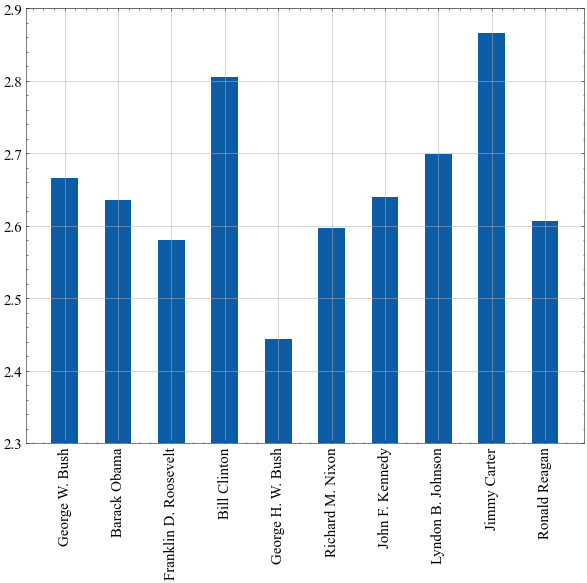

In [4]:
x_axis_data = np.array([i for i in range(len(focal_presidents))])
x_axis_data_labels = list(map(lambda idx: focal_presidents[idx], x_axis_data))

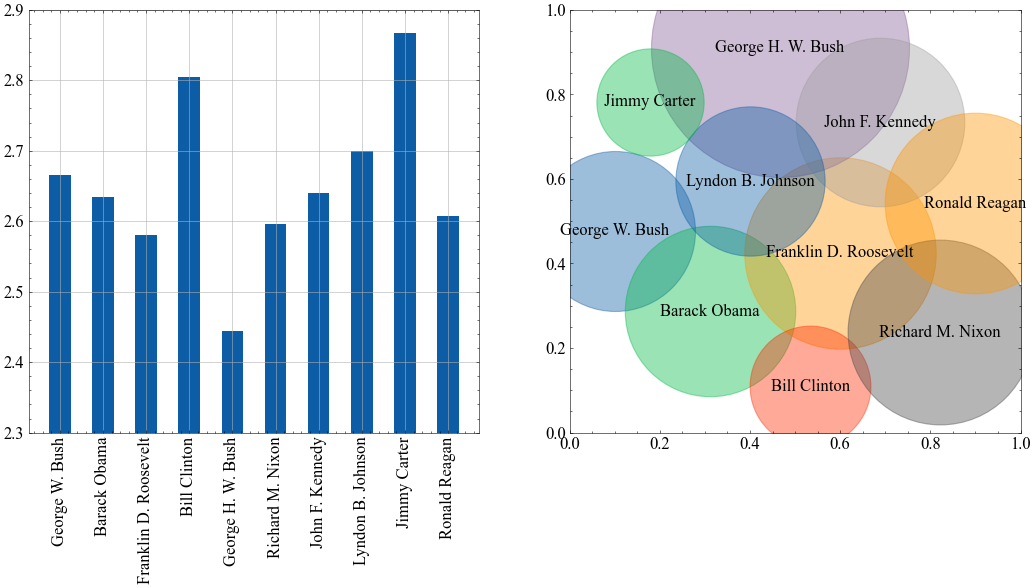

In [121]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
# tsneDoc = TSNE(n_components=2).fit_transform(audio_embedding.values)
scaler = MinMaxScaler((0.1, 0.9))
sd_tsne = scaler.fit_transform(tsneDoc)
fig, axis = plt.subplots(1, 2, figsize=(16, 7), dpi=80)

axis[0].bar(x_axis_data, df['Voice Uniquiality'].values, 0.5, align='center')
axis[0].grid()
axis[0].set_xticks(x_axis_data)
axis[0].set_xticklabels(x_axis_data_labels, rotation=90, fontsize=15)
axis[0].set_ylim([2.3, 2.9])
axis[0].tick_params(axis='both', which='major', labelsize=15)

for i in range(len(focal_presidents)):
    axis[1].scatter(sd_tsne[i, 0], sd_tsne[i, 1]+0.01, s=1e9 / df.loc[i, 'Voice Uniquiality']**11, alpha=0.4)
    axis[1].text(x=sd_tsne[i, 0], y=sd_tsne[i, 1], s=focal_presidents[i], fontsize=15, ha='center', fontweight=500)
    axis[1].set_xlim([0, 1])
    axis[1].set_ylim([0, 1])
    axis[1].tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [17]:
tsneDoc[i, 0]/np.sqrt(tsneDoc[i, 0]**2+tsneDoc[i, 1]**2)

0.8924236647019329

In [82]:
df.loc[i, 'Voice Uniquiality']**3 * 100

1772.039710710737

In [123]:
or_df = pd.read_csv('../dataset/bert_text_features.csv', index_col=0)

In [126]:
df.to_csv('../dataset/cnn_audio_features.csv', index=False)

In [135]:
pd.merge(or_df,df.set_index('Name'), how='inner', left_index=True, right_index=True).to_csv('final_dataset.csv')

In [137]:
or_df = pd.read_csv('../dataset/bert_agg_embedding.csv', index_col=0)

In [141]:
pd.merge(or_df, audio_embedding, how='inner', left_index=True, right_index=True).to_csv('../dataset/final_embedding.csv')

In [140]:
or_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
President,,,,,,,,,,,,,,,,,,,,,
Barack Obama,0.674488,-0.051211,0.522782,0.625229,-0.080163,0.127319,0.130125,0.071122,0.335872,-0.263286,...,-0.138610,0.163017,-0.120851,-0.649033,0.584100,0.323876,0.107414,-0.297508,0.473270,0.000440
Bill Clinton,0.446532,0.184790,0.496045,0.479644,-0.505556,-0.154721,0.168330,0.101857,0.382282,-0.463003,...,0.420861,0.100441,0.080743,-0.639456,0.695801,0.200528,-0.260103,-0.512873,0.532883,0.055867
Franklin D. Roosevelt,-0.183074,0.210947,0.348554,-0.377743,-0.029855,-0.553623,-0.072233,0.854023,0.279167,-0.760826,...,0.415602,0.604815,0.549783,-0.595625,0.040920,-0.363617,0.089900,-0.441554,-0.468767,0.131448
George H. W. Bush,0.460357,-0.255423,0.693780,0.634954,-0.088986,-0.028627,-0.151582,-0.099644,0.390948,-0.284184,...,0.247826,0.294723,0.065769,-0.749072,0.673614,0.290044,-0.059131,-0.232323,0.525454,0.110978
George W. Bush,0.454063,0.101698,0.560779,0.789709,0.093683,0.010383,0.015519,-0.031103,0.477362,-0.470565,...,-0.132690,0.209147,-0.090263,-0.710402,0.686328,-0.033212,-0.014354,-0.408098,0.292094,-0.269736
Jimmy Carter,0.479685,-0.178567,0.723497,0.427192,0.142472,-0.605707,-0.126505,0.346928,0.464202,-0.194221,...,0.284865,0.518247,0.268454,-0.806755,0.372624,-0.112205,-0.030450,-0.355798,0.465635,0.162002
John F. Kennedy,0.042074,0.424095,0.819145,0.138655,-0.004174,-0.578290,-0.588960,0.477560,0.436369,-0.392942,...,0.733307,0.596342,0.489470,-0.628724,0.485689,-0.111005,0.008182,-0.097190,-0.230902,0.397004
Lyndon B. Johnson,0.198983,0.359381,0.968072,0.564082,0.134263,-0.519960,-0.791520,-0.133444,0.659269,-0.297859,...,0.718911,0.702935,0.530519,-0.940026,0.441063,-0.153094,0.123207,0.031091,0.311079,0.088936
Richard M. Nixon,-0.150548,0.313039,0.591975,-0.054436,-0.194157,-0.960864,-0.238394,0.417991,0.573475,-0.143097,...,0.716797,0.749003,0.666042,-0.776238,0.040073,-0.167919,-0.159520,-0.325672,0.175543,0.143244
